In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/df_cleaned_model_ready.parquet')


KeyError: 'text'

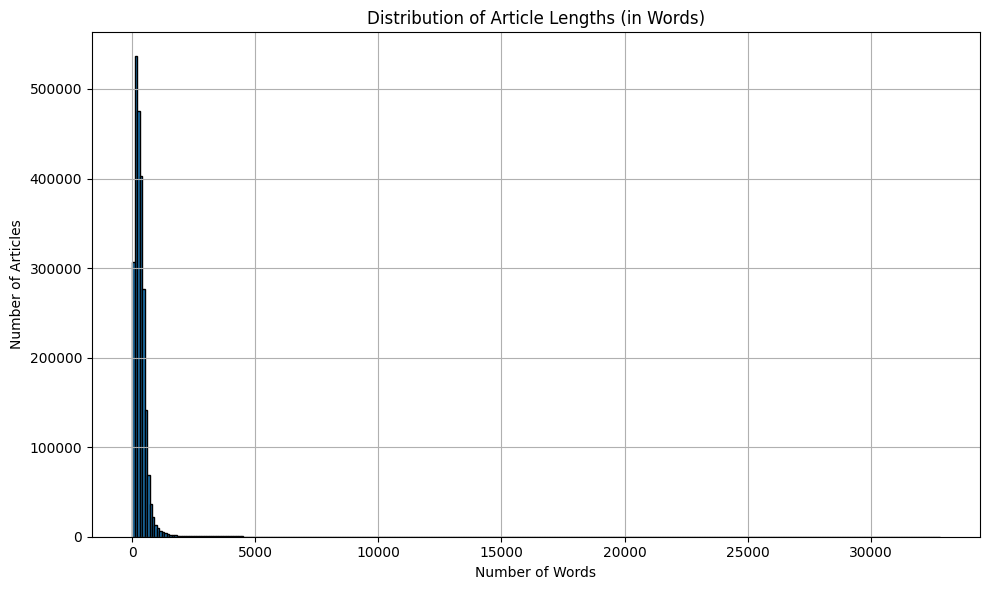

In [ ]:
# Calculate text lengths in words
df['text_length'] = df['text_clean'].apply(lambda x: len(str(x).split()))

# Plot histogram with bins of 100 words
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=range(0, df['text_length'].max() + 100, 100), edgecolor='black')
plt.title('Distribution of Article Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()
plt.show()

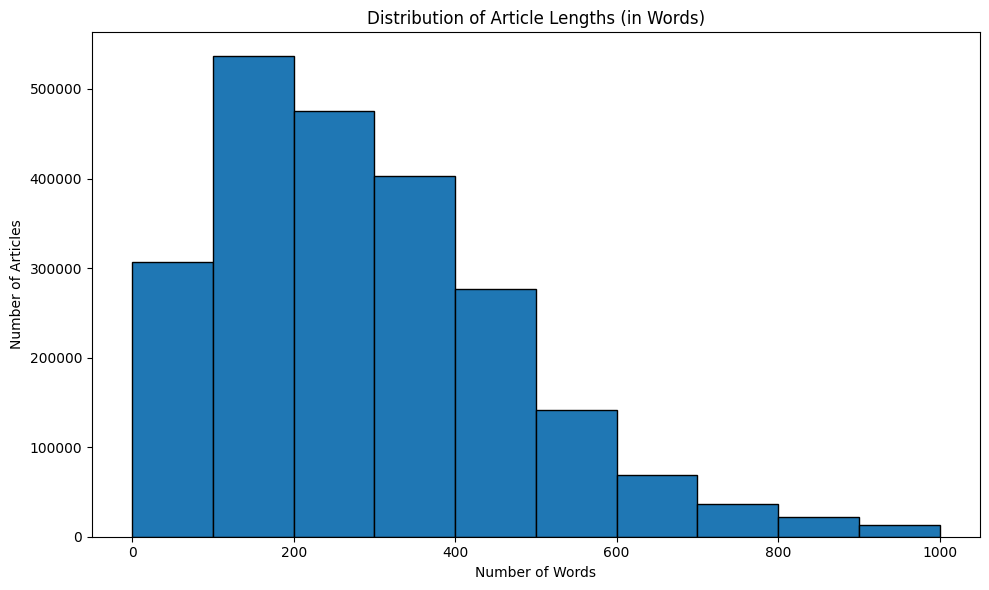

In [ ]:
# Filter out outliers (keep only articles with < 2000 words)
df_filtered = df[df['text_length'] < 1000]

# Plot histogram with bins of 100 words
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['text_length'], bins=range(0, 1001, 100), edgecolor='black')
plt.title('Distribution of Article Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Compute average article length overall
overall_avg_length = df['text_length'].mean()
print(f"Overall average article length: {overall_avg_length:.2f} words")

# Compute average article length by bias label
avg_lengths_by_class = df.groupby('bias_label')['text_length'].mean()
print("\nAverage article length by political bias:")
print(avg_lengths_by_class)


Overall average article length: 327.36 words

Average article length by political bias:
bias_label
center    290.761688
left      370.331169
right     320.656371
Name: text_length, dtype: float64


In [ ]:
# Install and download spaCy English model
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Show progress bar
tqdm.pandas()

# Sample 50k per class (150k total)
df_sample = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42))
      .reset_index(drop=True)
)

# Define POS tagging function
def count_pos(text):
    doc = nlp(str(text))
    noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
    adj_count = sum(1 for token in doc if token.pos_ == "ADJ")
    return pd.Series([noun_count, adj_count])

# Apply POS tagging to sample
df_sample[['noun_count', 'adj_count']] = df_sample['text_clean'].progress_apply(count_pos)

# Add text length (for normalization later)
df_sample['text_length'] = df_sample['text_clean'].apply(lambda x: len(str(x).split()))

# Normalize counts
df_sample['noun_ratio'] = df_sample['noun_count'] / df_sample['text_length'].replace(0, 1)
df_sample['adj_ratio'] = df_sample['adj_count'] / df_sample['text_length'].replace(0, 1)

# Optional: preview result
df_sample[['bias_label', 'noun_ratio', 'adj_ratio']].groupby('bias_label').mean()


<ipython-input-11-195dab33c3ca>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42))
100%|██████████| 150000/150000 [1:33:39<00:00, 26.69it/s]


,noun_ratio,adj_ratio
bias_label,,
center,0.419887,0.109057
left,0.414513,0.120781
right,0.399973,0.107328


In [ ]:
import pandas as pd

# Assuming df_sample already contains 'noun_count', 'adj_count', and 'bias_label' columns

# Group by bias label and calculate mean of noun and adj counts
avg_counts = df_sample.groupby('bias_label')[['noun_count', 'adj_count']].mean()

# Display result
print(avg_counts)


            noun_count  adj_count
bias_label                       
center       123.17764   32.77656
left         155.79058   46.22488
right        128.23376   35.85536


<Figure size 800x600 with 0 Axes>

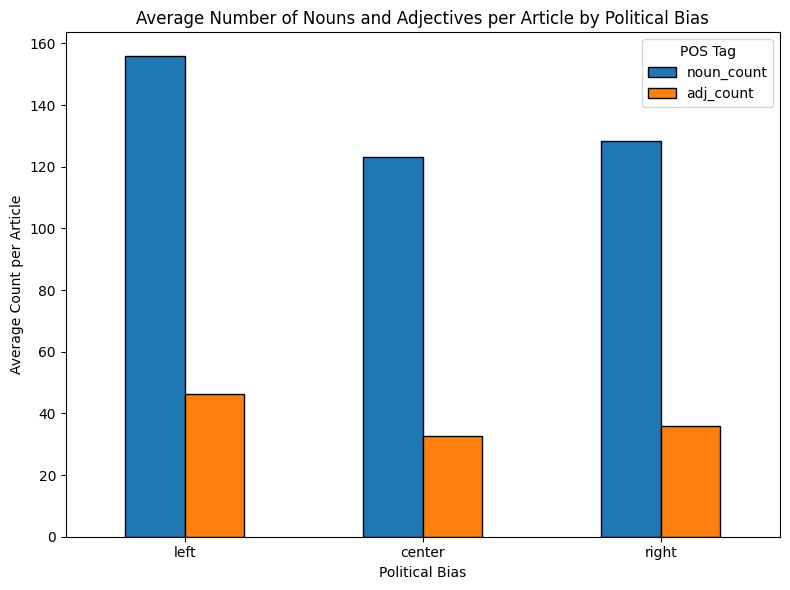

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example POS tag averages from your analysis
data = {
    'bias_label': ['left', 'center', 'right'],
    'noun_count': [155.79, 123.18, 128.23],
    'adj_count': [46.22, 32.78, 35.86]
}

# Create DataFrame
df_pos_avg = pd.DataFrame(data)

# Set index for plotting
df_pos_avg.set_index('bias_label', inplace=True)

# Plot
plt.figure(figsize=(8, 6))
df_pos_avg.plot(kind='bar', figsize=(8, 6), edgecolor='black')

plt.title('Average Number of Nouns and Adjectives per Article by Political Bias')
plt.ylabel('Average Count per Article')
plt.xlabel('Political Bias')
plt.xticks(rotation=0)
#plt.grid(axis='y')
plt.tight_layout()
plt.legend(title='POS Tag')
plt.show()


In [ ]:
from collections import Counter
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
tqdm.pandas()

# Define token filtering function
def extract_filtered_words(text):
    doc = nlp(str(text).lower())
    return [token.text for token in doc if token.is_alpha and token.text not in stopwords]

# Dictionary to store results
top_words_by_class = {}

# Loop through each bias class
for label in df_sample['bias_label'].unique():
    # Filter rows for the current label
    subset = df_sample[df_sample['bias_label'] == label]

    # Apply word extraction
    all_words = subset['text_clean'].progress_apply(extract_filtered_words)

    # Flatten and count
    flattened = [word for sublist in all_words for word in sublist]
    counter = Counter(flattened)

    # Store top 50
    top_words_by_class[label] = counter.most_common(50)

# Display top 50 words per class
for label, words in top_words_by_class.items():
    print(f"\nTop 50 words for class '{label}':")
    for word, count in words:
        print(f"{word}: {count}")


100%|██████████| 50000/50000 [29:01<00:00, 28.71it/s]



Top 50 words for class 'center':
said: 213473
president: 56802
new: 56555
state: 53587
nt: 53316
trump: 52670
people: 50479
house: 44052
year: 37167
states: 36428
s: 34261
government: 32450
years: 31287
million: 31179
time: 30153
federal: 29601
health: 27389
law: 26924
percent: 26899
public: 26206
senate: 25531
says: 24849
national: 24154
including: 24048
told: 23228
according: 22982
court: 22945
obama: 22622
democrats: 22239
officials: 21874
police: 21593
republican: 21511
campaign: 21335
white: 21127
security: 21029
week: 20946
like: 20862
department: 20598
support: 20254
report: 19895
republicans: 19744
tax: 19720
congress: 19688
administration: 19563
country: 19326
american: 19034
office: 18808
committee: 18773
democratic: 18668
work: 18599

Top 50 words for class 'left':
said: 200228
nt: 81905
people: 76094
new: 71711
president: 70347
mr: 59211
state: 57144
states: 54490
trump: 54274
s: 52172
government: 48144
time: 44404
years: 43667
like: 43409
house: 42800
percent: 40095
obama